In [9]:
#importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import math
from IPython.display import clear_output

In [10]:
#loading H matrix from Hmatrix.mat file and converting it to numpy array
mat = scipy.io.loadmat('Hmatrix3.mat')
arr = mat['H'] # arr is Hmatrix


In [11]:
#creating p evenly spaced
p = np.linspace(0, 1.1, 11, endpoint = False)
print(p)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [12]:
col = len(arr[0])#number of columns
row = len(arr)#number of rows
print(col)
print(row)

12
9


In [13]:
code=np.zeros(col)  # Input of BEC Channel 
nsuc=np.zeros(len(p)) # Array to store success  
cnt=0
Nsim = 100
Li_prev=np.zeros(col)# For Breaking Condition

In [14]:
counter = -1
for p1 in p:
    counter+=1
    for b in range(Nsim): # Monte-Carlo Simulation
        clear_output(wait = True)
        print(counter+(np.round((b/Nsim)*100, 2))/100,"%")
        noise = []
        for x in range(col): # noise generated
            if random.random() < p1:
                noise.append(1)
            else:
                noise.append(0)
        
        Msg_received1=[]
        for x in range(len(code)):
            Msg_received1.append(code[x]-noise[x]) # Generating Random Message after adding noise
        llr=np.zeros(col) # log likelihood ratio
       
        #Loading The Message from VN to CN
        
        for i in range(col):     # Initializing Log-Likelihood ratio
            if Msg_received1[i]==1:
                llr[i]=-np.inf
            elif(Msg_received1[i]==0):
                llr[i]=np.inf
            else:
                llr[i]=0       # For erasures odds in favour of 0 is 1 therefore LLR will be 0
        
        Mij=np.zeros((row,col)) # LLR Ratio's VN to CN
        Mij=Mij-1
        for i in range(row):
            for j in range(col): 
                if arr[i][j]==1: # storing LLR of VN connected to CN in matrix
                    Mij[i][j]=llr[j] # Generating M matrix (similar to Hmatrix) and replacing 1 with LLR

        Eij=np.zeros((row,col)) # CN calculation
        for i in range(row):
            for j in range(col):
                if Mij[i][j]!=-1: # checking whether there is any value of LLR present in matrix
                    temp_cnt=1
                    not_ii=j
                    for ii in range(col):
                        if (ii!=not_ii) and (Mij[i][ii]!=-1):
                            Mj_I=Mij[i][ii]
                            temp_cnt=temp_cnt * math.tanh(Mj_I/2) # Probabilities passing from VN to CN
                    if(1+temp_cnt == 0):
                        Eij[i][j]=-np.inf
                    elif(1-temp_cnt == 0):
                        Eij[i][j]=np.inf
                    else:
                        Eij[i][j]=math.log((1+temp_cnt)/(1-temp_cnt)) # Loading LLR of all mulitplied probabilites 
                     # LLR of CN thinks that VN is 0 / CN thinks that VN is 1
                    
        Li=np.zeros(col) # Decision Boundary
        temp_total = 0
       
        for i in range(col):
            for j in range(row):
                temp_total += Eij[j][i]
            onlylj = temp_total + llr[i] # Adding llr of all the CN->VN and llr from channel
            Li[i]=onlylj
        
        Msg_received=np.zeros(col)
        for i in range(col):     # Decision Boundary
            if Li[i]==-np.inf:
                Msg_received[i]=1
            elif(Li[i]==np.inf):
                Msg_received[i]=0
            else:
                Msg_received[i]=-1

       
        
        if(np.sum(Msg_received)==0): # If decoded message is all zeros 
            nsuc[cnt]=nsuc[cnt]+1
        else:
            for iit in range(50):       # Iteration loop
                Mji=np.zeros((row,col))
                Mji=Mji-1
                for i in range(row):
                    for j in range(col):
                        if arr[i][j]==1:
                            temp_cnt=0
                            not_ii=i
                            for ii in range(row):
                                if (Eij[ii][j]!=0) and (ii!=not_ii):
                                    temp_cnt=temp_cnt+Eij[ii][j]                       
                            Mji[i][j]=temp_cnt+llr[j]
                
                Eij=np.zeros((row,col))
                for i in range(row):
                    for j in range(col):
                        if Mji[i][j]!=-1:
                            temp_cnt=1
                            not_ii=j
                            for ii in range(col):
                                if (ii!=not_ii) and (Mji[i][ii]!=-1):
                                    Mj_I=Mji[i][ii]
                                    temp_cnt=temp_cnt * math.tanh(Mj_I/2)
                            if(1+temp_cnt == 0):
                                Eij[i][j]=-np.inf
                            elif(1-temp_cnt == 0):
                                Eij[i][j]=np.inf
                            else:
                                Eij[i][j]=math.log((1+temp_cnt)/(1-temp_cnt))
                            
                
                Li=np.zeros(col)
                temp_total = 0
                for i in range(col):
                    for j in range(row):
                        temp_total += Eij[j][i]
                    Li[i] = temp_total + llr[i]

                if (Li.all()==Li_prev.all()):# If LLR does not change after iteration
                   # It means that no further decoding is possible
                   # This code can't be decoded
                     break
                Li_prev=Li
                Msg_received=np.zeros(col)
                for i in range(col):
                    if Li[i]==-np.inf:
                        Msg_received[i]=1
                    elif(Li[i]==np.inf):
                        Msg_received[i]=0
                    else:
                        Msg_received[i]=-1
                
                if(np.sum(Msg_received)==0): # Successfully decoded
                    nsuc[cnt]=nsuc[cnt]+1  # incrementing the counter
                    break
    cnt=cnt+1

10.99 %


In [15]:
array_plot = []

Text(0, 0.5, 'Probability of success')

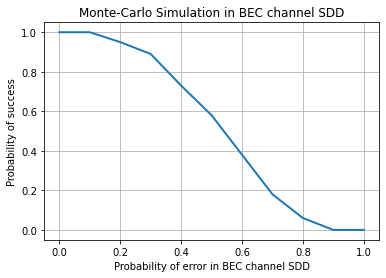

In [16]:
array_plot = []
for x in nsuc:
    array_plot.append(x/Nsim)
plt.plot(p,array_plot,linewidth = 2)
plt.grid()
plt.title("Monte-Carlo Simulation in BEC channel SDD")
plt.xlabel("Probability of error in BEC channel SDD")
plt.ylabel("Probability of success") 
